Note:

Dropped  the timestamps, we only use indexes.
This also removed the large holes in the dataset, and data is not filled in anymore.

I have seen a lot of steps without lots of movement of the buy price. I then resampled the data to 1 hour intervals by using the median of every 12 steps.

**interesting enough, this has helped a lot of bringing in movement in the forecast**

why this is helping im not sure, maybe it trains the model to assume more movement than there really is?

In [1]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
from darts.models import LightGBMModel
import pandas as pd
import numpy as np
import matplotlib
import tempfile
from darts.models import LightGBMModel
from darts.metrics import mape, rmse, mae
import mlflow
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

In [3]:
# Download source data from s3
from ml.common.folder_s3_sync import download_folder_from_s3

datapath = "../../../data/train_lightgbm/gw2/"


download_folder_from_s3(s3_folder_prefix='datasources/gw2/raw/1763399444', local_folder=datapath)

df = pd.read_csv(f'{datapath}Copper Ore.csv', delimiter=";")


Source: ost-s3/datasources/gw2/raw/1763399444
Target: ../../../data/train_lightgbm/gw2/

Found 60 files to download

⊘ +1 Agony Infusion.csv (already exists, ETag matches)
⊘ Auric Sliver.csv (already exists, ETag matches)
⊘ Bag of Coffee Beans.csv (already exists, ETag matches)
⊘ Bag of Sugar.csv (already exists, ETag matches)
⊘ Black Lion Chest.csv (already exists, ETag matches)
⊘ Bowl of Candy Corn Custard.csv (already exists, ETag matches)
⊘ Choya Spine.csv (already exists, ETag matches)
⊘ Congealed Putrescence.csv (already exists, ETag matches)
⊘ Copper Ore.csv (already exists, ETag matches)
⊘ Cup of Spiced Apple Cider.csv (already exists, ETag matches)
⊘ Elder Wood Log.csv (already exists, ETag matches)
⊘ Eye of Kormir.csv (already exists, ETag matches)
⊘ Flawless Snowflake.csv (already exists, ETag matches)
⊘ Fried Golden Dumpling.csv (already exists, ETag matches)
⊘ Glass of Buttered Spirits.csv (already exists, ETag matches)
⊘ Glob of Ectoplasm.csv (already exists, ETag matches

In [4]:
from darts import TimeSeries

def get_series_resampled(path, resample_interval):
    df = pd.read_csv(path, delimiter=";")
    value_cols = ["buy_unit_price"]

    tsdf = df[value_cols].copy()

    # Reset index to use integer index instead of timestamp
    tsdf = tsdf.reset_index(drop=True)

    if resample_interval > 1:
        tsdf = tsdf.groupby(tsdf.index // resample_interval).median()


    # Create TimeSeries with integer index
    series = TimeSeries.from_dataframe(tsdf, value_cols=value_cols)


    return series

sample = get_series_resampled(f"{datapath}Copper Ore.csv", resample_interval=12)

<Axes: xlabel='time'>

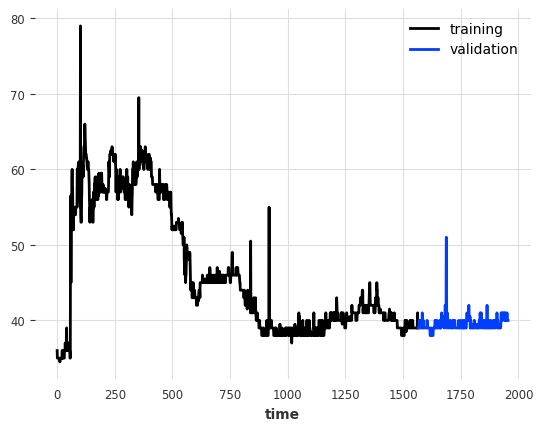

In [5]:
def train_val_split(series, split_percentage):
    train, val = series.split_after(split_percentage)
    return train, val

samples = get_series_resampled(f"{datapath}Copper Ore.csv", resample_interval=12)
samplet, samplev = train_val_split(samples, split_percentage=0.8)
samplet.plot(label="training")
samplev.plot(label="validation")

In [6]:
def train_lightgbm_model(item="Jute Scrap.csv",run_name="lightgbm", resample_interval=12, split_percentage=0.8,
                         lags=256, output_chunk_length=256, mlflow_nested_run = False):
    """
    Train a LightGBM model for time series forecasting.

    Parameters:
    -----------
    item : str
        Name of the CSV file to load (e.g., "Jute Scrap.csv")
    resample_interval : int
        Interval for resampling the data
    split_percentage : float
        Percentage for train/validation split (0.0 to 1.0)
    lags : int
        Number of lags to use in the model
    output_chunk_length : int
        Output chunk length for the model

    Returns:
    --------
    tuple
        (model, train, val, pred, metrics_dict)
    """


    with mlflow.start_run(run_name=run_name, nested=mlflow_nested_run):
        # Load and prepare data
        series_sampled = get_series_resampled(f"{datapath}{item}", resample_interval=resample_interval)
        train, val = train_val_split(series_sampled, split_percentage)
        prediction_horizon = len(val)

        # Model parameters
        model_params = {
            "lags": lags,
            "lags_past_covariates": None,
            "lags_future_covariates": None,
            "output_chunk_length": output_chunk_length,
            "force_row_wise": True,
            "device": "gpu",
        }

        # Log parameters
        mlflow.log_params({
            "resample_interval": resample_interval,
            "train_test_split": split_percentage,
            "prediction_horizon": prediction_horizon,
            **model_params
        })

        # Train model
        model = LightGBMModel(**model_params)
        model.fit(train)

        # Make predictions
        pred = model.predict(n=prediction_horizon)

        # Calculate metrics
        val_short = val[:prediction_horizon]
        mape_score = mape(val_short, pred)
        rmse_score = rmse(val_short, pred)
        mae_score = mae(val_short, pred)

        # Log metrics
        metrics_dict = {
            "mape": mape_score,
            "rmse": rmse_score,
            "mae": mae_score
        }
        mlflow.log_metrics(metrics_dict)

        # Save and log artifacts
        with tempfile.TemporaryDirectory() as tmpdir:
            train.to_csv(f"{tmpdir}/train.csv")
            val.to_csv(f"{tmpdir}/val.csv")
            pred.to_csv(f"{tmpdir}/pred.csv")
            mlflow.log_artifacts(tmpdir, artifact_path="series")

            # Create and log the prediction plot
            fig, ax = plt.subplots(figsize=(12, 6))
            train[-200:].plot(label="training", ax=ax)
            val_short.plot(label="validation", ax=ax)
            pred.plot(label="prediction", ax=ax)
            ax.legend()
            ax.set_title(f"Model Predictions vs Actual Values - {item}")

            # Log the figure directly without saving to disk
            mlflow.log_figure(fig, "prediction_plot.png")
            plt.close(fig)

        # Log model
        mlflow.sklearn.log_model(model.model, "lightgbm_model")

        # Log additional info
        mlflow.set_tags({
            "dataset": item.removesuffix(".csv"),
            "model_type": "LightGBM",
            "framework": "Darts"
        })

        # Print results
        print(f"MAPE: {mape_score:.2f}%")
        print(f"RMSE: {rmse_score:.2f}")
        print(f"MAE: {mae_score:.2f}")

        # Plot results
        train[-200:].plot(label="training")
        val_short.plot(label="validation")
        pred.plot(label="prediction")

        return model, train, val, pred, metrics_dict

In [7]:
from itertools import product
import mlflow

def grid_search_lightgbm(items, param_grid, experiment_name="lightgbm_gridsearch"):
    """
    Perform grid search over LightGBM parameters for multiple items.

    Parameters:
    -----------
    items : list of str
        List of CSV file names to test
    param_grid : dict
        Dictionary with parameter names as keys and lists of values to test
        Example: {
            'resample_interval': [6, 12, 24],
            'lags': [128, 256, 512],
            'output_chunk_length': [128, 256],
            'split_percentage': [0.7, 0.8]
        }
    experiment_name : str
        MLflow experiment name

    Returns:
    --------
    pd.DataFrame
        Results of all combinations with metrics
    """
    mlflow.set_experiment(experiment_name)

    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = []
    total_runs = len(combinations) * len(items)
    current_run = 0

    with mlflow.start_run(run_name="grid_search_parent"):
        for item in items:
            for combo in combinations:
                current_run += 1
                params = dict(zip(param_names, combo))

                run_name = f"{item.removesuffix('.csv')}_" + "_".join([f"{k}={v}" for k, v in params.items()])

                print(f"\n[{current_run}/{total_runs}] Training: {run_name}")

                try:
                    model, train, val, pred, metrics = train_lightgbm_model(
                        item=item,
                        run_name=run_name,
                        mlflow_nested_run=True,
                        **params
                    )

                    result = {
                        'item': item,
                        **params,
                        **metrics,
                        'status': 'success'
                    }
                    print(f"✓ Success - MAPE: {metrics['mape']:.2f}%, RMSE: {metrics['rmse']:.2f}")

                except Exception as e:
                    result = {
                        'item': item,
                        **params,
                        'mape': None,
                        'rmse': None,
                        'mae': None,
                        'status': 'failed',
                        'error': str(e)
                    }
                    print(f"✗ Failed - Error: {e}")

                results.append(result)

        # Create summary DataFrame
        results_df = pd.DataFrame(results)

        # Save results as artifact
        with tempfile.TemporaryDirectory() as tmpdir:
            results_path = f"{tmpdir}/grid_search_results.csv"
            results_df.to_csv(results_path, index=False)
            mlflow.log_artifact(results_path)

            # Create summary statistics
            if results_df['mape'].notna().any():
                summary = results_df[results_df['status'] == 'success'].groupby('item').agg({
                    'mape': ['min', 'mean', 'max'],
                    'rmse': ['min', 'mean', 'max'],
                    'mae': ['min', 'mean', 'max']
                })
                summary_path = f"{tmpdir}/summary_by_item.csv"
                summary.to_csv(summary_path)
                mlflow.log_artifact(summary_path)

                print("\n" + "="*80)
                print("SUMMARY BY ITEM:")
                print("="*80)
                print(summary)

    return results_df

In [ ]:
items = [
    "Copper Ore.csv",
    "Iron Ore.csv",
    "Gold Ore.csv",
    "Gold Ingot.csv",
    "Silver Ore.csv",
    "Mithril Ore.csv",
    "Bag of Sugar.csv"
]

# Define parameter grid
param_grid = {
    'resample_interval': [1,6,12,24],
    'lags': [32,64,128,256],
    'output_chunk_length': [32,128,256]
}

# Run grid search
results_df = grid_search_lightgbm(items, param_grid)

# Display results
print("\n" + "="*80)
print("ALL RESULTS:")
print("="*80)
print(results_df)


[1/336] Training: Copper Ore_resample_interval=1_lags=32_output_chunk_length=32
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1408
[LightGBM] [Info] Number of data points in the train set: 18710, number of used features: 32
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 32 dense feature groups (0.57 MB) transferred to GPU in 0.004461 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 46.346766
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1408
[LightGBM] [Info] Number of data points in the train set: 18710, number of used features: 32
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs hav

2025/11/23 01:51:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:51:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:51:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 1.62%
RMSE: 1.32
MAE: 0.67
🏃 View run Copper Ore_resample_interval=1_lags=32_output_chunk_length=32 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/0eb5eb82ec594e5ca71b37c31456b8c8
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 1.62%, RMSE: 1.32

[2/336] Training: Copper Ore_resample_interval=1_lags=32_output_chunk_length=128
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1408
[LightGBM] [Info] Number of data points in the train set: 18614, number of used features: 32
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 32 dense feature groups (0.57 MB) transferred to GPU in 0.000376 secs. 0 sparse feature groups
[LightGBM]

2025/11/23 01:51:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:51:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:51:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.33%
RMSE: 1.32
MAE: 0.93
🏃 View run Copper Ore_resample_interval=1_lags=32_output_chunk_length=128 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/a78ea46a372941a0bdbb4367b395470c
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 2.33%, RMSE: 1.32

[3/336] Training: Copper Ore_resample_interval=1_lags=32_output_chunk_length=256
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1408
[LightGBM] [Info] Number of data points in the train set: 18486, number of used features: 32
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 32 dense feature groups (0.56 MB) transferred to GPU in 0.000347 secs. 0 sparse feature groups
[LightGBM

2025/11/23 01:52:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:52:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:52:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.27%
RMSE: 1.31
MAE: 0.91
🏃 View run Copper Ore_resample_interval=1_lags=32_output_chunk_length=256 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/b6003c3133fd4bf285f39db069f24649
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 2.27%, RMSE: 1.31

[4/336] Training: Copper Ore_resample_interval=1_lags=64_output_chunk_length=32
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2816
[LightGBM] [Info] Number of data points in the train set: 18678, number of used features: 64
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 64 dense feature groups (1.14 MB) transferred to GPU in 0.000732 secs. 0 sparse feature groups
[LightGBM]

2025/11/23 01:52:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:52:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:52:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 1.61%
RMSE: 1.33
MAE: 0.66
🏃 View run Copper Ore_resample_interval=1_lags=64_output_chunk_length=32 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/b5666ff76fa74cff9f2ea2ed3f88aec6
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 1.61%, RMSE: 1.33

[5/336] Training: Copper Ore_resample_interval=1_lags=64_output_chunk_length=128
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2816
[LightGBM] [Info] Number of data points in the train set: 18582, number of used features: 64
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 64 dense feature groups (1.13 MB) transferred to GPU in 0.000786 secs. 0 sparse feature groups
[LightGBM]

2025/11/23 01:53:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:53:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:53:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.26%
RMSE: 1.30
MAE: 0.91
🏃 View run Copper Ore_resample_interval=1_lags=64_output_chunk_length=128 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/947b6a8aa35e4285b505d72c9c3b4aa1
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 2.26%, RMSE: 1.30

[6/336] Training: Copper Ore_resample_interval=1_lags=64_output_chunk_length=256
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2816
[LightGBM] [Info] Number of data points in the train set: 18454, number of used features: 64
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 64 dense feature groups (1.13 MB) transferred to GPU in 0.000586 secs. 0 sparse feature groups
[LightGBM

2025/11/23 01:54:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:54:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:54:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.04%
RMSE: 1.43
MAE: 0.84
🏃 View run Copper Ore_resample_interval=1_lags=64_output_chunk_length=256 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/3e126a44e2b240c384d1935a3191f9d3
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 2.04%, RMSE: 1.43

[7/336] Training: Copper Ore_resample_interval=1_lags=128_output_chunk_length=32
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5632
[LightGBM] [Info] Number of data points in the train set: 18614, number of used features: 128
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 128 dense feature groups (2.27 MB) transferred to GPU in 0.001057 secs. 0 sparse feature groups
[LightG

2025/11/23 01:54:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:54:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:54:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 1.61%
RMSE: 1.34
MAE: 0.67
🏃 View run Copper Ore_resample_interval=1_lags=128_output_chunk_length=32 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/2c94d2b5cc444857a49c7e47495d3337
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 1.61%, RMSE: 1.34

[8/336] Training: Copper Ore_resample_interval=1_lags=128_output_chunk_length=128
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5632
[LightGBM] [Info] Number of data points in the train set: 18518, number of used features: 128
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 128 dense feature groups (2.26 MB) transferred to GPU in 0.000852 secs. 0 sparse feature groups
[Light

2025/11/23 01:54:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:55:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:55:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 1.91%
RMSE: 1.40
MAE: 0.79
🏃 View run Copper Ore_resample_interval=1_lags=128_output_chunk_length=128 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/bfdd129496164db4aeb90fac6fd88d14
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 1.91%, RMSE: 1.40

[9/336] Training: Copper Ore_resample_interval=1_lags=128_output_chunk_length=256
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5632
[LightGBM] [Info] Number of data points in the train set: 18390, number of used features: 128
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 128 dense feature groups (2.24 MB) transferred to GPU in 0.000826 secs. 0 sparse feature groups
[Ligh

2025/11/23 01:55:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:56:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:56:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.16%
RMSE: 1.28
MAE: 0.86
🏃 View run Copper Ore_resample_interval=1_lags=128_output_chunk_length=256 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/5682dc39496d4161bc4e63742756752e
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 2.16%, RMSE: 1.28

[10/336] Training: Copper Ore_resample_interval=1_lags=256_output_chunk_length=32
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11200
[LightGBM] [Info] Number of data points in the train set: 18486, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (4.51 MB) transferred to GPU in 0.001525 secs. 0 sparse feature groups
[Lig

2025/11/23 01:56:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:56:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:56:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 1.66%
RMSE: 1.35
MAE: 0.69
🏃 View run Copper Ore_resample_interval=1_lags=256_output_chunk_length=32 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/7cdf7b899fc44e1784e6df9d74b16721
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 1.66%, RMSE: 1.35

[11/336] Training: Copper Ore_resample_interval=1_lags=256_output_chunk_length=128
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11200
[LightGBM] [Info] Number of data points in the train set: 18390, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (4.49 MB) transferred to GPU in 0.001629 secs. 0 sparse feature groups
[Lig

2025/11/23 01:56:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:56:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:56:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.19%
RMSE: 1.29
MAE: 0.88
🏃 View run Copper Ore_resample_interval=1_lags=256_output_chunk_length=128 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/53bd35c8a79e49da94fc189ec2160334
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 2.19%, RMSE: 1.29

[12/336] Training: Copper Ore_resample_interval=1_lags=256_output_chunk_length=256
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11200
[LightGBM] [Info] Number of data points in the train set: 18262, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (4.46 MB) transferred to GPU in 0.001557 secs. 0 sparse feature groups
[Li

2025/11/23 01:58:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:58:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:58:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.12%
RMSE: 1.28
MAE: 0.85
🏃 View run Copper Ore_resample_interval=1_lags=256_output_chunk_length=256 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/47a7ef7ba54645a4a4b050dd5c46e8b4
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 2.12%, RMSE: 1.28

[13/336] Training: Copper Ore_resample_interval=6_lags=32_output_chunk_length=32
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1858
[LightGBM] [Info] Number of data points in the train set: 3066, number of used features: 32
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 32 dense feature groups (0.09 MB) transferred to GPU in 0.000299 secs. 0 sparse feature groups
[LightGBM

2025/11/23 01:58:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:58:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:58:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.61%
RMSE: 1.49
MAE: 1.06
🏃 View run Copper Ore_resample_interval=6_lags=32_output_chunk_length=32 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/e5c880ddd77a4f76a8e7d4200dedcab0
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 2.61%, RMSE: 1.49

[14/336] Training: Copper Ore_resample_interval=6_lags=32_output_chunk_length=128
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1858
[LightGBM] [Info] Number of data points in the train set: 2970, number of used features: 32
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 32 dense feature groups (0.09 MB) transferred to GPU in 0.000360 secs. 0 sparse feature groups
[LightGBM]

2025/11/23 01:58:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:58:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:58:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.29%
RMSE: 1.24
MAE: 0.91
🏃 View run Copper Ore_resample_interval=6_lags=32_output_chunk_length=128 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/64c1fb10fe104ef7b8321b245ce80716
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 2.29%, RMSE: 1.24

[15/336] Training: Copper Ore_resample_interval=6_lags=32_output_chunk_length=256
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1858
[LightGBM] [Info] Number of data points in the train set: 2842, number of used features: 32
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 32 dense feature groups (0.09 MB) transferred to GPU in 0.000954 secs. 0 sparse feature groups
[LightGBM

2025/11/23 01:59:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:59:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:59:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 3.48%
RMSE: 1.79
MAE: 1.38
🏃 View run Copper Ore_resample_interval=6_lags=32_output_chunk_length=256 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/c150f9dc5c70452780f95dac306bf48e
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 3.48%, RMSE: 1.79

[16/336] Training: Copper Ore_resample_interval=6_lags=64_output_chunk_length=32
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3714
[LightGBM] [Info] Number of data points in the train set: 3034, number of used features: 64
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 64 dense feature groups (0.19 MB) transferred to GPU in 0.000530 secs. 0 sparse feature groups
[LightGBM]

2025/11/23 01:59:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 01:59:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 01:59:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.75%
RMSE: 1.54
MAE: 1.11
🏃 View run Copper Ore_resample_interval=6_lags=64_output_chunk_length=32 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/5669827b232f431da459f80ccf811151
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 2.75%, RMSE: 1.54

[17/336] Training: Copper Ore_resample_interval=6_lags=64_output_chunk_length=128
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3714
[LightGBM] [Info] Number of data points in the train set: 2938, number of used features: 64
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 64 dense feature groups (0.18 MB) transferred to GPU in 0.000631 secs. 0 sparse feature groups
[LightGBM]

2025/11/23 02:00:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 02:00:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 02:00:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 3.06%
RMSE: 1.55
MAE: 1.21
🏃 View run Copper Ore_resample_interval=6_lags=64_output_chunk_length=128 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/6c531208b876436c824efbd19a8660a8
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 3.06%, RMSE: 1.55

[18/336] Training: Copper Ore_resample_interval=6_lags=64_output_chunk_length=256
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3714
[LightGBM] [Info] Number of data points in the train set: 2810, number of used features: 64
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 64 dense feature groups (0.17 MB) transferred to GPU in 0.000629 secs. 0 sparse feature groups
[LightGBM

2025/11/23 02:00:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 02:01:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 02:01:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 3.92%
RMSE: 1.97
MAE: 1.56
🏃 View run Copper Ore_resample_interval=6_lags=64_output_chunk_length=256 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/c8a97eddc0494f40b52f9d2f77bfc4c7
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 3.92%, RMSE: 1.97

[19/336] Training: Copper Ore_resample_interval=6_lags=128_output_chunk_length=32
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 2970, number of used features: 128
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 128 dense feature groups (0.36 MB) transferred to GPU in 0.001906 secs. 0 sparse feature groups
[LightG

2025/11/23 02:01:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 02:01:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 02:01:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.70%
RMSE: 1.51
MAE: 1.09
🏃 View run Copper Ore_resample_interval=6_lags=128_output_chunk_length=32 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/f41e808b638c4958a2b86c538328d99c
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 2.70%, RMSE: 1.51

[20/336] Training: Copper Ore_resample_interval=6_lags=128_output_chunk_length=128
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 2874, number of used features: 128
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 128 dense feature groups (0.35 MB) transferred to GPU in 0.000969 secs. 0 sparse feature groups
[Light

2025/11/23 02:01:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 02:01:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 02:01:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.87%
RMSE: 1.58
MAE: 1.14
🏃 View run Copper Ore_resample_interval=6_lags=128_output_chunk_length=128 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/30c0c10994d145738e24f444720f567d
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 2.87%, RMSE: 1.58

[21/336] Training: Copper Ore_resample_interval=6_lags=128_output_chunk_length=256
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 2746, number of used features: 128
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 128 dense feature groups (0.34 MB) transferred to GPU in 0.002411 secs. 0 sparse feature groups
[Ligh

2025/11/23 02:02:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 02:02:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 02:02:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 3.43%
RMSE: 1.71
MAE: 1.36
🏃 View run Copper Ore_resample_interval=6_lags=128_output_chunk_length=256 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/e1b354c0bdc0474c996c4ccfc21f88a4
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 3.43%, RMSE: 1.71

[22/336] Training: Copper Ore_resample_interval=6_lags=256_output_chunk_length=32
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 14471
[LightGBM] [Info] Number of data points in the train set: 2842, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (0.69 MB) transferred to GPU in 0.001346 secs. 0 sparse feature groups
[Ligh

2025/11/23 02:02:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 02:02:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 02:02:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 3.34%
RMSE: 1.71
MAE: 1.33
🏃 View run Copper Ore_resample_interval=6_lags=256_output_chunk_length=32 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/1d25d724959d4ed49710bc0962204f28
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 3.34%, RMSE: 1.71

[23/336] Training: Copper Ore_resample_interval=6_lags=256_output_chunk_length=128
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 14471
[LightGBM] [Info] Number of data points in the train set: 2746, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (0.67 MB) transferred to GPU in 0.001196 secs. 0 sparse feature groups
[Ligh

2025/11/23 02:03:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 02:03:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 02:03:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 3.41%
RMSE: 1.73
MAE: 1.35
🏃 View run Copper Ore_resample_interval=6_lags=256_output_chunk_length=128 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/a0d3553617b64246b25414c1db3d10b9
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 3.41%, RMSE: 1.73

[24/336] Training: Copper Ore_resample_interval=6_lags=256_output_chunk_length=256
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 14471
[LightGBM] [Info] Number of data points in the train set: 2618, number of used features: 256
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (0.64 MB) transferred to GPU in 0.001390 secs. 0 sparse feature groups
[Lig

2025/11/23 02:04:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 02:04:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 02:04:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 3.33%
RMSE: 1.69
MAE: 1.32
🏃 View run Copper Ore_resample_interval=6_lags=256_output_chunk_length=256 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/cc26eba089ba41dfae813d501523c501
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 3.33%, RMSE: 1.69

[25/336] Training: Copper Ore_resample_interval=12_lags=32_output_chunk_length=32
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 1502, number of used features: 32
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 32 dense feature groups (0.05 MB) transferred to GPU in 0.000607 secs. 0 sparse feature groups
[LightGB

2025/11/23 02:04:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 02:04:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/23 02:04:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MAPE: 2.60%
RMSE: 1.38
MAE: 1.03
🏃 View run Copper Ore_resample_interval=12_lags=32_output_chunk_length=32 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10/runs/6da15ecb92c84cdead1c7c3a1443c31d
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/10
✓ Success - MAPE: 2.60%, RMSE: 1.38

[26/336] Training: Copper Ore_resample_interval=12_lags=32_output_chunk_length=128
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 32
[LightGBM] [Info] Using GPU Device: gfx1151, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 32 dense feature groups (0.04 MB) transferred to GPU in 0.000294 secs. 0 sparse feature groups
[LightGB

In [ ]:
# Compare Grid Search Results from MLflow
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def get_gridsearch_results(experiment_name="lightgbm_gridsearch"):
    """
    Pull all grid search runs from MLflow and create a comparison DataFrame.

    Parameters:
    -----------
    experiment_name : str
        Name of the MLflow experiment

    Returns:
    --------
    pd.DataFrame
        DataFrame with all runs and their metrics/parameters
    """
    client = MlflowClient()

    # Get experiment
    experiment = client.get_experiment_by_name(experiment_name)
    if experiment is None:
        print(f"Experiment '{experiment_name}' not found!")
        return None

    # Get all runs from the experiment
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string="",
        order_by=["metrics.mape ASC"]
    )

    # Extract data from runs
    runs_data = []
    for run in runs:
        run_data = {
            'run_id': run.info.run_id,
            'run_name': run.info.run_name,
            'status': run.info.status,
            'start_time': pd.to_datetime(run.info.start_time, unit='ms'),
        }

        # Add parameters
        run_data.update({f'param_{k}': v for k, v in run.data.params.items()})

        # Add metrics
        run_data.update({f'metric_{k}': v for k, v in run.data.metrics.items()})

        # Add tags
        run_data.update({f'tag_{k}': v for k, v in run.data.tags.items()})

        runs_data.append(run_data)

    df = pd.DataFrame(runs_data)

    # Clean up column names and convert types
    if 'param_resample_interval' in df.columns:
        df['param_resample_interval'] = pd.to_numeric(df['param_resample_interval'], errors='coerce')
    if 'param_lags' in df.columns:
        df['param_lags'] = pd.to_numeric(df['param_lags'], errors='coerce')
    if 'param_output_chunk_length' in df.columns:
        df['param_output_chunk_length'] = pd.to_numeric(df['param_output_chunk_length'], errors='coerce')

    return df


# Get results
results_df = get_gridsearch_results()

if results_df is not None and len(results_df) > 0:
    print(f"Found {len(results_df)} runs")
    print("\n" + "=" * 80)
    print("TOP 10 RUNS BY MAPE:")
    print("=" * 80)

    # Display top runs
    display_cols = [col for col in results_df.columns if
                    col.startswith(('run_name', 'metric_', 'param_', 'tag_dataset'))]
    top_runs = results_df[display_cols].head(10)
    print(top_runs.to_string())

    # Filter out parent runs (they don't have actual predictions)
    child_runs = results_df[~results_df['run_name'].str.contains('parent', case=False, na=False)]

    if len(child_runs) > 0:
        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. MAPE distribution by resample_interval
        if 'param_resample_interval' in child_runs.columns and 'metric_mape' in child_runs.columns:
            ax = axes[0, 0]
            child_runs.boxplot(column='metric_mape', by='param_resample_interval', ax=ax)
            ax.set_title('MAPE Distribution by Resample Interval')
            ax.set_xlabel('Resample Interval')
            ax.set_ylabel('MAPE')
            plt.sca(ax)
            plt.xticks(rotation=0)

        # 2. MAPE vs RMSE scatter
        if 'metric_mape' in child_runs.columns and 'metric_rmse' in child_runs.columns:
            ax = axes[0, 1]
            if 'tag_dataset' in child_runs.columns:
                for dataset in child_runs['tag_dataset'].unique():
                    data = child_runs[child_runs['tag_dataset'] == dataset]
                    ax.scatter(data['metric_mape'], data['metric_rmse'], label=dataset, alpha=0.6)
                ax.legend()
            else:
                ax.scatter(child_runs['metric_mape'], child_runs['metric_rmse'], alpha=0.6)
            ax.set_xlabel('MAPE')
            ax.set_ylabel('RMSE')
            ax.set_title('MAPE vs RMSE')
            ax.grid(True, alpha=0.3)

        # 3. Metric comparison for different datasets
        if 'tag_dataset' in child_runs.columns and 'metric_mape' in child_runs.columns:
            ax = axes[1, 0]
            dataset_stats = child_runs.groupby('tag_dataset')['metric_mape'].agg(['mean', 'min', 'max'])
            dataset_stats.plot(kind='bar', ax=ax)
            ax.set_title('MAPE Statistics by Dataset')
            ax.set_xlabel('Dataset')
            ax.set_ylabel('MAPE')
            ax.legend(['Mean', 'Min', 'Max'])
            plt.sca(ax)
            plt.xticks(rotation=45, ha='right')

        # 4. Heatmap of parameters vs MAPE (if we have varying parameters)
        ax = axes[1, 1]
        param_cols = [col for col in child_runs.columns if col.startswith('param_') and child_runs[col].nunique() > 1]

        if len(param_cols) > 0 and 'metric_mape' in child_runs.columns:
            # Create a pivot table for the first varying parameter
            main_param = param_cols[0]
            if 'tag_dataset' in child_runs.columns:
                pivot_data = child_runs.pivot_table(
                    values='metric_mape',
                    index='tag_dataset',
                    columns=main_param,
                    aggfunc='mean'
                )
                sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=ax)
                ax.set_title(f'Average MAPE Heatmap\n(Dataset vs {main_param.replace("param_", "")})')
            else:
                ax.text(0.5, 0.5, 'Insufficient data for heatmap',
                        ha='center', va='center', transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, 'No varying parameters found',
                    ha='center', va='center', transform=ax.transAxes)

        plt.tight_layout()
        plt.show()

        # Summary statistics
        print("\n" + "=" * 80)
        print("SUMMARY STATISTICS:")
        print("=" * 80)

        if 'metric_mape' in child_runs.columns:
            print(f"\nOverall MAPE: {child_runs['metric_mape'].mean():.2f} ± {child_runs['metric_mape'].std():.2f}")
            print(f"Best MAPE: {child_runs['metric_mape'].min():.2f}")
            print(f"Worst MAPE: {child_runs['metric_mape'].max():.2f}")

        if 'tag_dataset' in child_runs.columns:
            print("\nBy Dataset:")
            print(child_runs.groupby('tag_dataset')[['metric_mape', 'metric_rmse', 'metric_mae']].agg(
                ['mean', 'min', 'max']))

        if 'param_resample_interval' in child_runs.columns:
            print("\nBy Resample Interval:")
            print(child_runs.groupby('param_resample_interval')[['metric_mape', 'metric_rmse', 'metric_mae']].mean())

        # Find best configuration
        if 'metric_mape' in child_runs.columns:
            best_run = child_runs.loc[child_runs['metric_mape'].idxmin()]
            print("\n" + "=" * 80)
            print("BEST CONFIGURATION:")
            print("=" * 80)
            for col in best_run.index:
                if col.startswith(('param_', 'metric_', 'tag_dataset', 'run_name')):
                    print(f"{col}: {best_run[col]}")

else:
    print("No runs found!")